### Bi-Metrics
#### Por Andrea Fuentes Pérez y Víctor Sánchez Auñón
#### 3º de Ingeniería Biomédica

VALIDACIÓN Y FORMATO DEL MRZ CON PRE-PROCESIONAMIENTO:

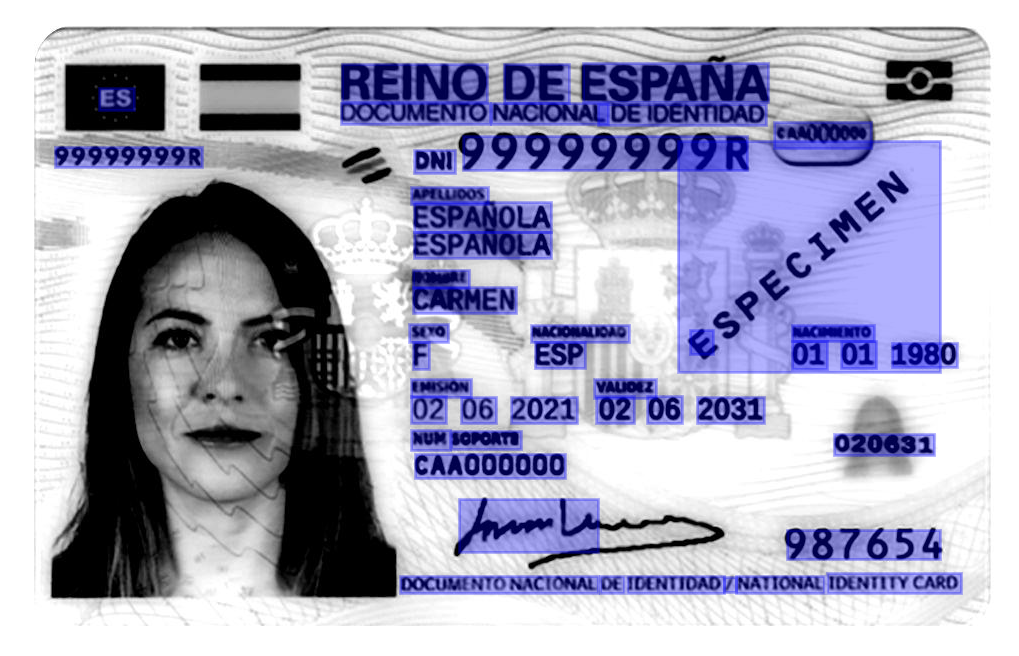

REINO DE ESPANA
ES
DOCUMENTO NACIONAL DEIDENTIDAD
CAA000000
99999999R
DNI 99999999R
APELLIDOS
ESPANOLA
ESPANOLA

CARMEN
SEYO
NACIONALIDAD
C
NACIMMENTO
F
ESP
01 01 1980

EMISION
VALIDEZ
02 06 2021 02 06 2031
NUM
020631
CAA000000
MMLE
987654
DOCUMENTONACIONAL DE IDENTIDAD / NATIONAL IDENTITYCARD


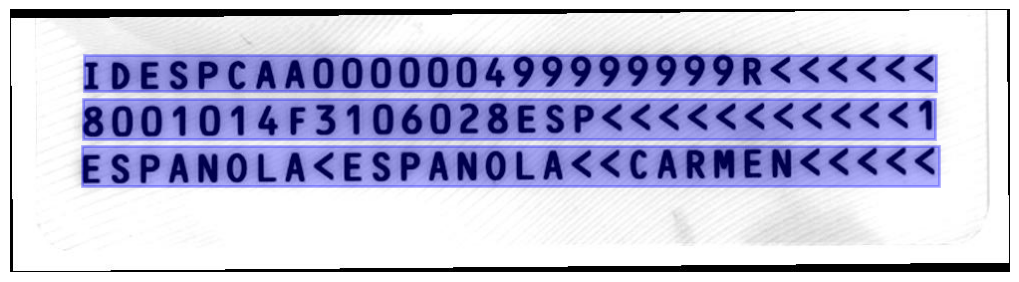

IDESPCAA000000499999999R<<<<<<
8001014F3106028ESP<<<<<<<<<<<1
ESPANOLAKESPANOLA<<CARMEN<<<<<


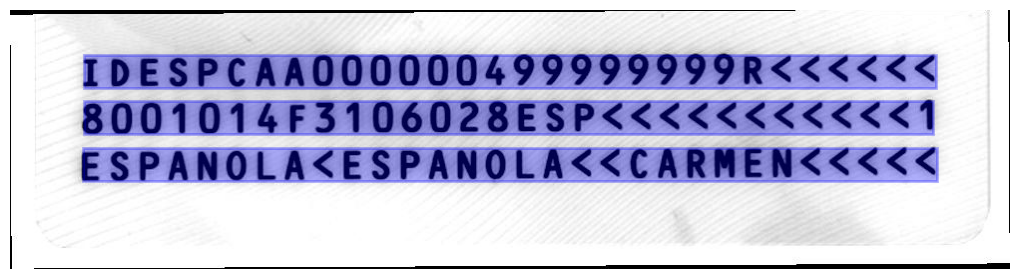

IDESPCAA000000499999999R<<<<<<
8001014F3106028ESP<<<<<<<<<<1
ESPANOLA<ESPANOLA<<CARMEN<<<<<



--MRZ--
linea1: IDESPCAA000000499999999R<<<<<< (longitud: 30)
linea2: 8001014F3106028ESP<<<<<<<<<<<1 (longitud: 30)
linea3: ESPANOLA<ESPANOLA<<CARMEN<<<<< (longitud: 30)


In [54]:
from doctr.io import DocumentFile
from doctr.models import ocr_predictor
from PIL import Image, ImageEnhance
import os

model = ocr_predictor(pretrained=True)

def extract_text(ocr_model, image_file_path: str, mrz: bool = False, angulo = 0):
    """Extrae el texto de una imagen a partir de un modelo OCR"""
    
    # --- INICIO PREPROCESAMIENTO ---
    # Abrimos, pasamos a gris y aumentamos contraste para resaltar los símbolos <
    img = Image.open(image_file_path).convert('L')

    ancho, alto = img.size
    if mrz:
        img = img.crop((0, alto*0.6, ancho, alto))
        img = img.rotate(angulo, resample=Image.Resampling.BICUBIC, expand=True)  
    img = ImageEnhance.Contrast(img).enhance(2.0)    
    temp_path = "temp_mrz_process.jpg"
    img.save(temp_path)
    # --- FIN PREPROCESAMIENTO ---

    doc = DocumentFile.from_images(temp_path)
    result = ocr_model(doc)
    
    # Limpiar archivo temporal
    if os.path.exists(temp_path):
        os.remove(temp_path)
        
    return result

def show_ocr_result(result):
    """Muestra una imagen de resultado y el texto extraido"""

    # mostrar resultado
    result.show()

    # mostrar texto con mas de 50% de confianza
    for page in result.pages:
        for block in page.blocks:
            for line in block.lines:
                words = []
                for word in line.words:
                    if word.confidence > 0.5:
                        words.append(word.value)
                
                
                print(' '.join(words).upper())

# extraer texto del front
# text_front = extract_text(model, './dni_fotos/dni_front_especimen.jpg')
# show_ocr_result(text_front)

# extraer texto del back

text_back = extract_text(model, './dni_fotos/front.jpg', angulo=0.5)
show_ocr_result(text_back)
text_back1 = extract_text(model, './dni_fotos/back.jpg', mrz=True, angulo=0.5)
show_ocr_result(text_back1)
text_back2 = extract_text(model, './dni_fotos/back.jpg', mrz=True, angulo=0.3)
show_ocr_result(text_back2)
mrz = {
    "linea1": text_back1.pages[0].blocks[0].lines[0].words[0].value,
    "linea2": text_back1.pages[0].blocks[0].lines[1].words[0].value,
    "linea3": text_back2.pages[0].blocks[0].lines[2].words[0].value
}
print("\n\n\n--MRZ--")
for key, value in mrz.items():
    print(f"{key}: {value} (longitud: {len(value)})")







CÁLCULO Y COMPROBACIÓN DE CHECKSUMS:

In [88]:
prueba = {
    "linea1": "IDESPCAA000000499999999R<<<<<<",
    "linea2": "8001014F3106028ESP<<<<<<<<<<<1",
    "linea3": "ESPANOLA<ESPANOLA<<CARMEN<<<<<"
}

num_docu = prueba["linea1"][5:14]
fecha_nac = prueba["linea2"][0:6]
#control es L1 sin ID ni pais (5 al final) + L2 sin sexo ni nacionalidad (0 a 7 + 8 a 15 + 18 a 29)
control = prueba["linea1"][5:] + prueba["linea2"][0:7] + prueba["linea2"][8:15] + prueba["linea2"][18:29]
def calculoHash(campo):
    total = 0
    posi = 0 #empieza en 0 -> *7, posi++ 1 -> *3, posi++ 2 -> *1 y posi - 2 
    valoresHash = [7, 3, 1]
    for char in campo:
        total += valorCharHash(char) * valoresHash[posi]
        
        if posi == 2:
            posi = 0
        else:
            posi += 1
    return total % 10 # cheksum = resto de 10 (es el ultimo digito)

def valorCharHash(char):
    if char.isdigit():
        return int(char)
    elif char == "<":
        return 0
    else:
        # A=65, si tiene q valer 10, entonces ord(A) - 55 = 10
        return ord(char) - 55

print("Hash numero documento: ", calculoHash(num_docu)) #4
print("Hash fecha nacimiento: ", calculoHash(fecha_nac)) #4
print("Hash control final: ", calculoHash(control)) #1


Hash numero documento:  4
Hash fecha nacimiento:  4
Hash control final:  1
